In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns
import pickle

sns.set_context("talk")
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr


from loren_frank_data_processing import (
    get_multiunit_dataframe,
    get_multiunit_dataframe2,
)

from src.load_data import load_data
from src.parameters import ANIMALS
from ZilongCode.utils import (
    get_steps,
    get_diffusion_exponent,
)

### 1, plot theta sequence example and replay sequence example

In [4]:
epoch_key = ("bon", 8, 4)
data = load_data(epoch_key)

Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules


In [5]:
datafolder = (
    "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/ThetaSweepTrajectories"
)

animal, day, epoch = epoch_key
# load the classifier results
cv_classifier_clusterless_results = xr.open_dataset(
    os.path.join(
        datafolder,
        f"{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc",
    )
)

# get all time slice
t = data["position_info"].index / np.timedelta64(1, "s")

# load multiunit times
multiunit_times = [
    get_multiunit_dataframe(tetrode_key, ANIMALS)
    for tetrode_key in data["tetrode_info"].index
]
if multiunit_times[0] is None:
    multiunit_times = [
        get_multiunit_dataframe2(tetrode_key, ANIMALS)
        for tetrode_key in data["tetrode_info"].index
    ]
# reset index in multiunit_times to seconds and replace the original multiunit_times
for i in range(len(multiunit_times)):
    indext_i = multiunit_times[i].index / np.timedelta64(1, "s")
    multiunit_times[i].index = indext_i

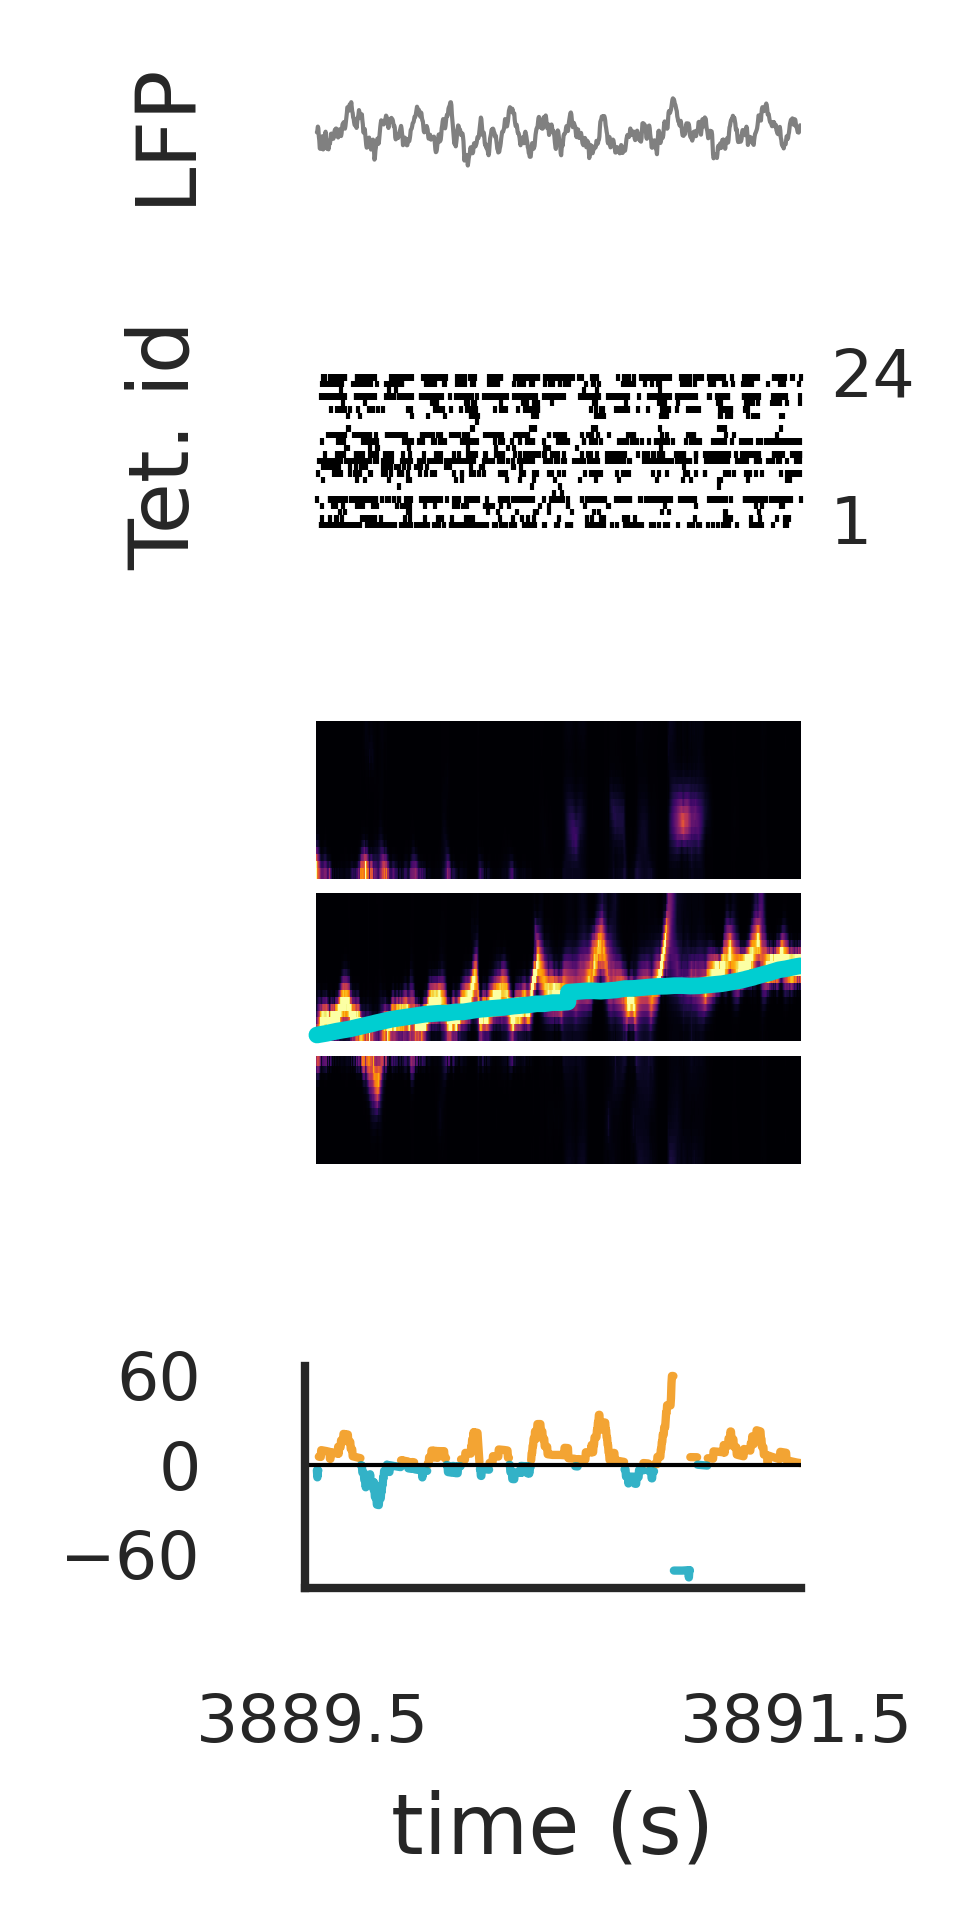

In [48]:
def plot_theta_examples(time_slice_sweep, t, multiunit_times, results, data):

    """
    Modified from https://github.com/edeno/replicate_kenny_analysis/blob/master/notebooks/Bond_day8_Epoch4.ipynb
    by Zilong, 30/08/2023
    plor the theta sweeps in time_slice
    Input:
        time_slice: the time slice to plot
        t: the time index
        results: the results from the model
        data: the data from the model
        add_zero_phase_index: whether to add the zero phase index
    Output:
        a plot with 3 subplots
    """

    cmap = plt.cm.inferno
    cmap.set_bad("white", alpha=1.0)
    labelsize = 10
    ticksize = 8
    # set background color to white
    sns.set_style("white")

    fig = plt.figure(figsize=(2, 3.5), dpi=300)

    gs = gridspec.GridSpec(4, 1, height_ratios=[0.5, 1, 3, 1.5])

    ax1 = plt.subplot(gs[0, 0])

    ind = 0
    lfp = (
        data["lfps"]
        .reset_index(drop=True)
        .set_index(data["lfps"].index / np.timedelta64(1, "s"))
    )

    # plot as curve, not fill
    ax1.plot(
        lfp.loc[time_slice_sweep].index.values,
        lfp.loc[time_slice_sweep].iloc[:, ind].values.squeeze(),
        color="grey",
        linewidth=0.5,
    )
    ax1.set_ylabel("LFP")

    # remove xticks
    ax1.set_xticks([])
    # remove y ticks
    ax1.set_yticks([])

    # ax2
    ax2 = plt.subplot(gs[1, 0])

    n_tetrodes = len(multiunit_times)

    # eventplot with small dot
    ax2.eventplot(
        [multiunit.loc[time_slice_sweep].index for multiunit in multiunit_times],
        color="black",
        clip_on=False,
        linewidths=0.5,
    )

    ax2.set_yticks((1, n_tetrodes))
    # move the y ticks to right
    ax2.yaxis.tick_right()
    # remove y tick bars
    ax2.tick_params(axis="y", length=0)
    ax2.set_ylim((1, n_tetrodes))
    ax2.set_ylabel("Tet. id")
    ax2.set_xticks([])
    sns.despine(ax=ax2, offset=5)
    ax2.spines["bottom"].set_visible(False)

    # ax 3
    ax3 = plt.subplot(gs[2, 0])
    # plot
    results["acausal_posterior"].sum("state", skipna=False).sel(
        time=time_slice_sweep
    ).plot(
        x="time",
        y="position",
        robust=True,
        ax=ax3,
        cmap=cmap,
        vmin=0.0,
    )

    ax3.plot(
        data["position_info"].reset_index().set_index(t).loc[time_slice_sweep].index,
        data["position_info"]
        .reset_index()
        .set_index(t)
        .loc[time_slice_sweep]
        .linear_position,
        color="darkturquoise",
        linestyle="-",
        linewidth=2,
        alpha=1,
    )

    # remove all labels, ticks and spines in axi, as well as colorbars
    ax3.set_xlabel("")
    ax3.set_ylabel("")
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.spines["right"].set_visible(False)
    ax3.spines["top"].set_visible(False)
    ax3.spines["left"].set_visible(False)
    ax3.spines["bottom"].set_visible(False)
    ax3.collections[0].colorbar.remove()

    # ax4
    ax4 = plt.subplot(gs[3, 0])
    # results.mental_distance_from_actual_position.sel(time=time_slice_sweep).plot(
    #     x="time", ax=ax4, color="#F18D00", linewidth=1, alpha=0.8
    # )

    # plot results.mental_distance_from_actual_position__ahead_behind.sel(time=time_slice_sweep)
    # with positive values as blue curve and negative values as orange curve with mask
    selected_data = results.mental_distance_from_actual_position_ahead_behind.sel(
        time=time_slice_sweep
    )
    selected_data.where(selected_data > 0).plot(
        x="time", ax=ax4, color="#F18D00", linewidth=1, alpha=0.8
    )
    selected_data.where(selected_data < 0).plot(
        x="time", ax=ax4, color="#009FB9", linewidth=1, alpha=0.8
    )

    # add a reference line at y=0 as black dashed line
    ax4.axhline(0, color="black", linestyle="-", linewidth=0.5)

    # set y label as 'Offset' and x label empty
    ax4.set_ylabel("", fontsize=labelsize)
    ax4.set_xlabel("time (s)", fontsize=labelsize)
    # set ticks off
    ax4.set_yticks([-60, 0, 60])
    # set x ticks with time_slice_sweep.start and time_slice_sweep.stop, keep one decimal
    ax4.set_xticks(
        [np.round(time_slice_sweep.start, 1), np.round(time_slice_sweep.stop, 1)]
    )
    # tick labels without scientific notation
    ax4.ticklabel_format(useOffset=False, style="plain")
    # set tick font size as ticksize
    ax4.tick_params(labelsize=ticksize)

    # set x ticks with time_slice_sweep.start and time_slice_sweep.stop, keep one decimal
    ax4.set_xticks(
        [np.round(time_slice_sweep.start, 1), np.round(time_slice_sweep.stop, 1)]
    )

    # add ripple times to the plot as red bars on top of the LFP
    # first get the ripples time within the time slice
    for i in data["ripple_times"].index:
        # get the ripple time
        ripple_time = data["ripple_times"].iloc[i - 1]
        start_time = ripple_time.loc["start_time"] / np.timedelta64(1, "s")
        end_time = ripple_time.loc["end_time"] / np.timedelta64(1, "s")
        # if start_time and end_time are both in the time slice. then add the ripple to the plot
        # x range is start_time to end_time, y range is [0,300]
        if start_time > time_slice_sweep.start and end_time < time_slice_sweep.stop:
            ax3.axvspan(
                start_time, end_time, ymin=0, ymax=1, color="grey", alpha=0.6, lw=0
            )
            ax4.axvspan(
                start_time, end_time, ymin=0, ymax=1, color="grey", alpha=0.3, lw=0
            )

    # set ticks and spines
    all_axes = fig.get_axes()
    for ax in all_axes:
        ax.tick_params(labelsize=ticksize)
        ax.xaxis.label.set_size(labelsize)
        ax.yaxis.label.set_size(labelsize)
        # set axes off bottom left top and right
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_xlim(time_slice_sweep.start - 0.05, time_slice_sweep.stop)
        ax.yaxis.set_label_coords(-0.2, 0.5)

    # add back ax4 bottom and left spines
    ax4.spines["bottom"].set_visible(True)
    ax4.spines["left"].set_visible(True)
    # set axis linewidth 1.0
    ax4.spines["bottom"].set_linewidth(1.0)
    ax4.spines["left"].set_linewidth(1.0)

    # align y labels of ax1 and ax2

    plt.tight_layout()

    # save the figure to /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/
    savedir = (
        "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/"
    )

    savename = "Fig_replay_vs_theta_sequences_thetasweepexample.pdf"
    plt.savefig(savedir + savename, dpi=300, bbox_inches="tight")


time_slice = slice(t.min(), t.max())  # 107-117
time_slice_sweep = slice(t.min() + 243.5, t.min() + 245.5)
plot_theta_examples(
    time_slice_sweep,
    t,
    multiunit_times,
    cv_classifier_clusterless_results,
    data,
)

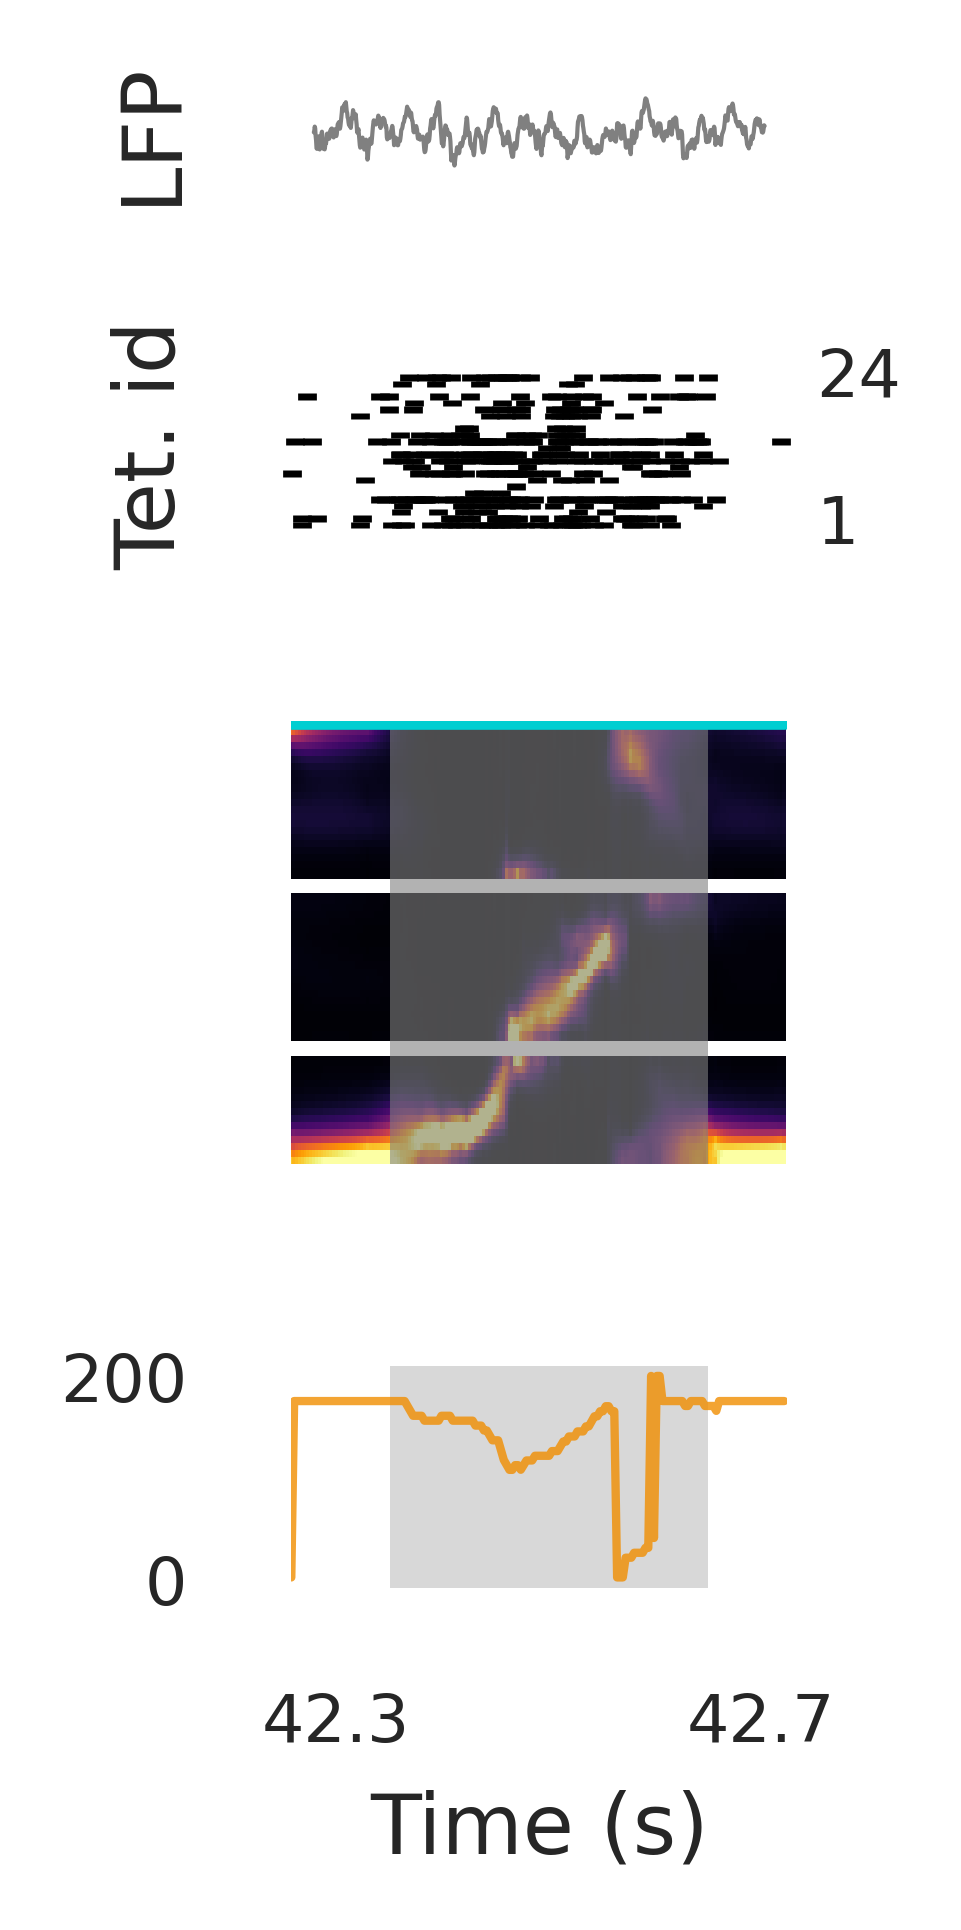

In [34]:
def plot_replay_trajectory(
    time_slice_replay, t, multiunit_times, results, data, figsize=(8, 3)
):

    """
    Modified from https://github.com/edeno/replicate_kenny_analysis/blob/master/notebooks/Bond_day8_Epoch4.ipynb
    by Zilong, 30/08/2023
    plor the theta sweeps in time_slice
    Input:
        time_slice_replay: the time slice to plot. a list
        t: the time index
        results: the results from the model
        data: the data from the model
        add_zero_phase_index: whether to add the zero phase index
    Output:
    """

    cmap = plt.cm.inferno
    cmap.set_bad("white", alpha=1.0)
    labelsize = 10
    ticksize = 8
    # set background color to white
    sns.set_style("white")

    fig = plt.figure(figsize=figsize, dpi=300)

    cols = len(time_slice_replay)
    gs = gridspec.GridSpec(4, cols, height_ratios=[0.5, 1, 3, 1.5])

    for i in range(cols):

        time_slice_replay_i = time_slice_replay[i]

        ax5 = plt.subplot(gs[0, i])
        ind = 0
        lfp = (
            data["lfps"]
            .reset_index(drop=True)
            .set_index(data["lfps"].index / np.timedelta64(1, "s"))
        )

        # plot as curve, not fill
        ax5.plot(
            lfp.loc[time_slice_sweep].index.values,
            lfp.loc[time_slice_sweep].iloc[:, ind].values.squeeze(),
            color="grey",
            linewidth=0.5,
        )
        ax5.set_ylabel("LFP")

        # remove xticks
        ax5.set_xticks([])
        # remove y ticks
        ax5.set_yticks([])

        ax3 = plt.subplot(gs[1, i])

        n_tetrodes = len(multiunit_times)

        ax3.eventplot(
            [multiunit.loc[time_slice_replay_i].index for multiunit in multiunit_times],
            color="black",
            clip_on=False,
        )

        ax3.set_yticks((1, n_tetrodes))
        ax3.set_ylim((1, n_tetrodes))
        ax3.set_ylabel("Tet. id")
        ax3.set_xticks([])
        sns.despine(ax=ax3, offset=5)
        ax3.spines["bottom"].set_visible(False)

        # move the y ticks to right
        ax3.yaxis.tick_right()
        # remove y tick bars
        ax3.tick_params(axis="y", length=0)

        ax0 = plt.subplot(gs[2, i])
        # plot
        results["acausal_posterior"].sum("state", skipna=False).sel(
            time=time_slice_replay_i
        ).plot(
            x="time",
            y="position",
            robust=True,
            ax=ax0,
            cmap=cmap,
            vmin=0.0,
        )

        ax0.plot(
            data["position_info"]
            .reset_index()
            .set_index(t)
            .loc[time_slice_replay_i]
            .index,
            data["position_info"]
            .reset_index()
            .set_index(t)
            .loc[time_slice_replay_i]
            .linear_position,
            color="darkturquoise",
            linestyle="-",
            linewidth=2,
            alpha=1,
        )

        # remove all labels, ticks and spines in axi, as well as colorbars
        ax0.set_xlabel("")
        ax0.set_ylabel("")
        ax0.set_yticks([])
        ax0.set_xticks([])
        ax0.spines["right"].set_visible(False)
        ax0.spines["top"].set_visible(False)
        ax0.spines["left"].set_visible(False)
        ax0.spines["bottom"].set_visible(False)
        ax0.collections[0].colorbar.remove()

        # ax1
        ax1 = plt.subplot(gs[3, i])
        results.mental_distance_from_actual_position.sel(time=time_slice_replay_i).plot(
            x="time", ax=ax1, color="#F18D00", linewidth=1, alpha=0.8
        )
        # set y label as 'Offset' and x label empty
        ax1.set_ylabel("", fontsize=labelsize)
        ax1.set_xlabel("Time (s)", fontsize=labelsize)
        # set ticks off
        ax1.set_yticks([0, 200])
        # set x ticks with time_slice_replay.start and time_slice_replay.stop without scientific notation
        ax1.set_xticks(
            [
                np.round(time_slice_replay_i.start, 1),
                np.round(time_slice_replay_i.stop, 1),
            ]
        )
        # tick labels without scientific notation
        ax1.ticklabel_format(useOffset=False, style="plain")
        # set tick labels
        ax1.set_xticklabels(
            [
                np.round(time_slice_replay_i.start - t.min(), 1),
                np.round(time_slice_replay_i.stop - t.min(), 1),
            ],
            fontsize=ticksize,
        )
        # set tick font size as ticksize
        ax1.tick_params(labelsize=ticksize)

        # add ripple times to the plot as red bars on top of the LFP
        # first get the ripples time within the time slice
        for k in data["ripple_times"].index:
            # get the ripple time
            ripple_time = data["ripple_times"].iloc[k - 1]
            start_time = ripple_time.loc["start_time"] / np.timedelta64(1, "s")
            end_time = ripple_time.loc["end_time"] / np.timedelta64(1, "s")
            # if start_time and end_time are both in the time slice. then add the ripple to the plot
            # x range is start_time to end_time, y range is [0,300]
            if (
                start_time > time_slice_replay_i.start
                and end_time < time_slice_replay_i.stop
            ):
                ax0.axvspan(
                    start_time, end_time, ymin=0, ymax=1, color="grey", alpha=0.6, lw=0
                )
                ax1.axvspan(
                    start_time, end_time, ymin=0, ymax=1, color="grey", alpha=0.3, lw=0
                )
        # add back ax1 bottom and left spines
        ax1.spines["bottom"].set_visible(True)
        ax1.spines["left"].set_visible(True)
        # set axis linewidth 1.0
        ax1.spines["bottom"].set_linewidth(1.0)
        ax1.spines["left"].set_linewidth(1.0)

        ax3.set_xlim(time_slice_replay_i.start, time_slice_replay_i.stop)
        ax0.set_xlim(time_slice_replay_i.start, time_slice_replay_i.stop)
        ax1.set_xlim(time_slice_replay_i.start, time_slice_replay_i.stop)

    # set ticks and spines
    all_axes = fig.get_axes()
    for ax in all_axes:
        ax.tick_params(labelsize=ticksize)
        ax.xaxis.label.set_size(labelsize)
        ax.yaxis.label.set_size(labelsize)
        # set axes off bottom left top and right
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.yaxis.set_label_coords(-0.2, 0.5)

    plt.tight_layout()

    # save the figure to /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/
    savedir = (
        "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/"
    )

    savename = "Fig_replay_vs_theta_sequences_replayexample.pdf"
    plt.savefig(savedir + savename, dpi=300, bbox_inches="tight")


time_slice_1 = slice(t.min() + 42.35, t.min() + 42.7)
# time_slice_2 = slice(t.min() + 89.45, t.min() + 89.9)
time_slice_3 = slice(t.min() + 509.45, t.min() + 509.9)
# time_slice_4 = slice(t.min() + 662.8, t.min() + 663.2)
# time_slice_5 = slice(t.min() + 866.3, t.min() + 866.7)

# time_slice_replay = [
#     time_slice_1,
#     # time_slice_2,
#     time_slice_3,
#     # time_slice_4,
#     # time_slice_5,
# ]

time_slice_replay = [time_slice_1]

plot_replay_trajectory(
    time_slice_replay,
    t,
    multiunit_times,
    cv_classifier_clusterless_results,
    data,
    figsize=(2, 3.5),
)

### 2, plot the distribution of theta sweep length and replay step size in a recording session

In [3]:
from ZilongCode.utils import (
    get_diffusion_exponent,
    bandpassfilter,
    get_zero_phase,
    get_steps,
)
import pandas as pd

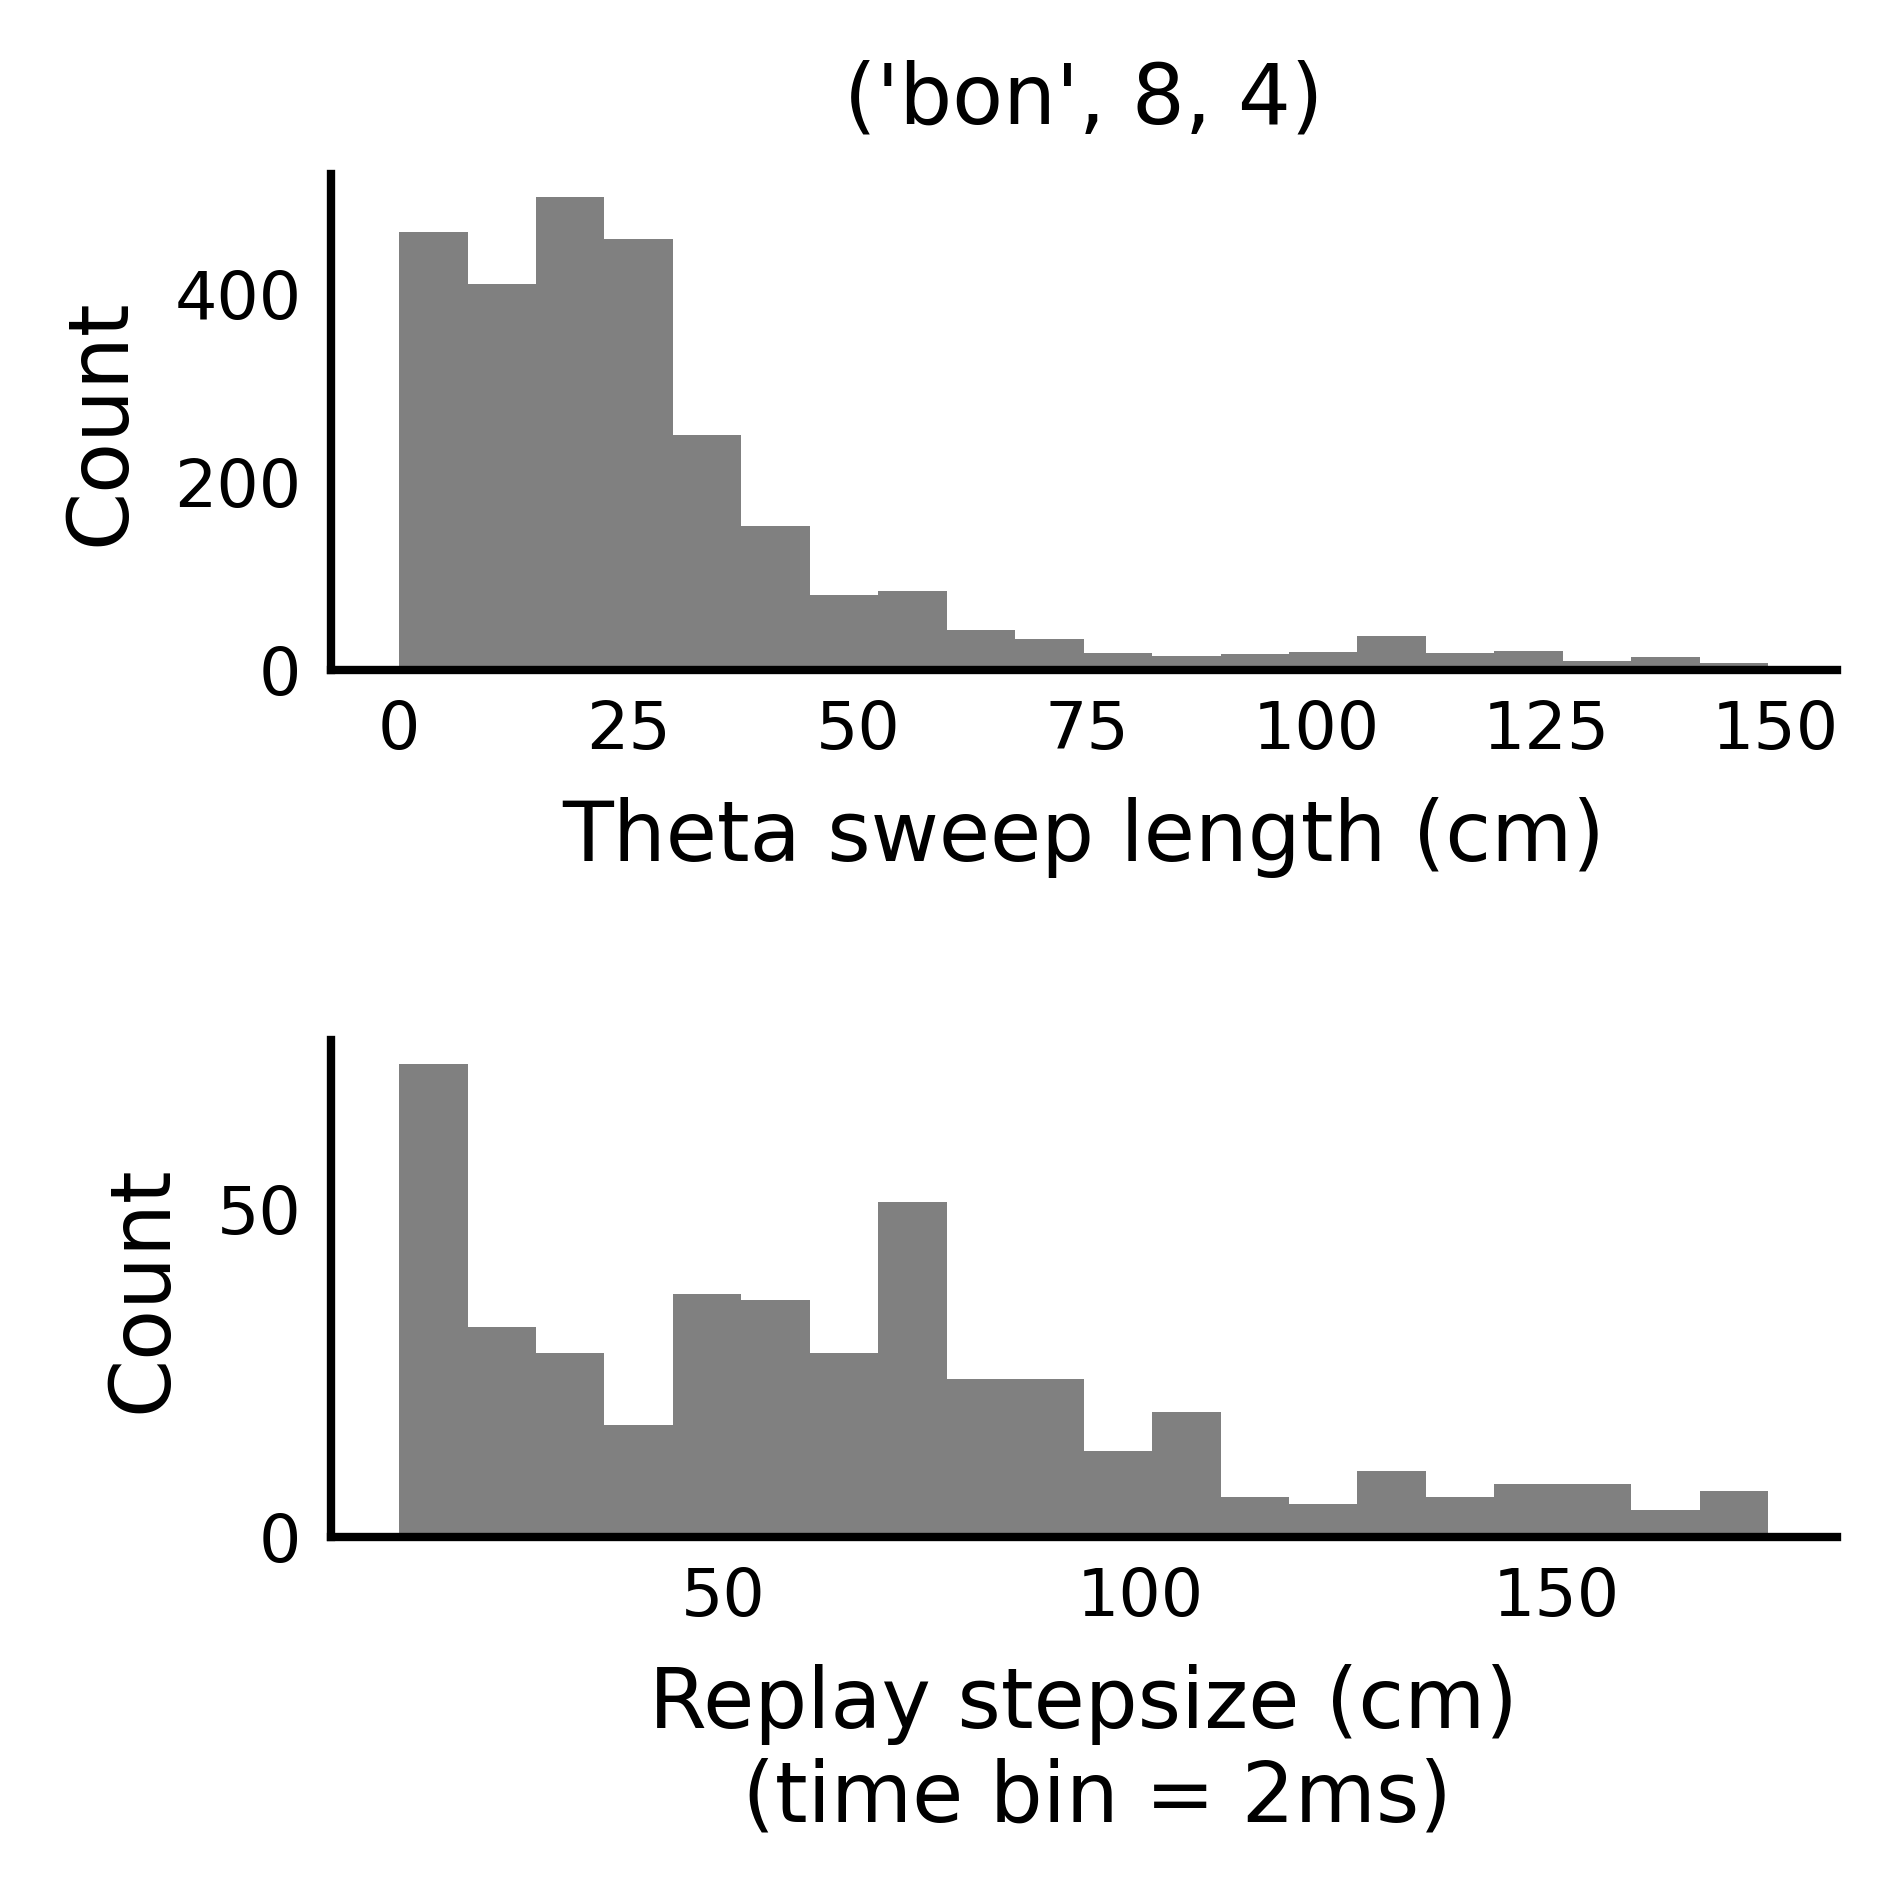

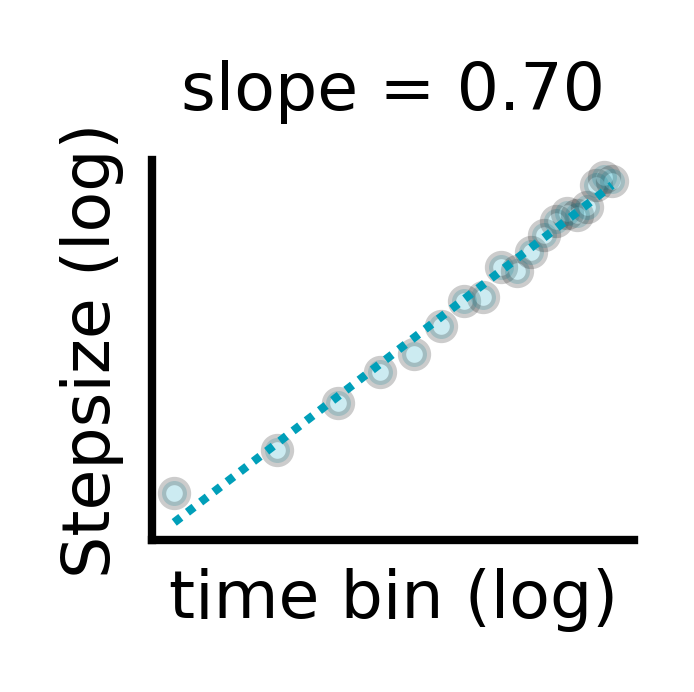

In [4]:
def get_sweep_length_and_replay_stepsize(epoch_key, datadir, sweep_speed_threshold=4):
    """
    Get the average sweep length and replay stepsize for the epoch
    """
    animal, day, epoch = epoch_key

    # 1, LOAD THETA SWEEPS RESULTS
    # load the classifier results
    cv_classifier_clusterless_results = xr.open_dataset(
        os.path.join(
            datadir,
            "ThetaSweepTrajectories",
            f"{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc",
        )
    )
    # load the data with pickle
    with open(
        os.path.join(
            datadir,
            "ThetaSweepTrajectories",
            f"{animal}_{day:02d}_{epoch:02d}_speed_info.pkl",
        ),
        "rb",
    ) as f:
        speed_dic = pickle.load(f)
        speed = speed_dic.values

    # load lfp info
    with open(
        os.path.join(
            datadir,
            "ThetaSweepTrajectories",
            f"{animal}_{day:02d}_{epoch:02d}_lfp_info.pkl",
        ),
        "rb",
    ) as f:
        lfp = pickle.load(f)

    lfp = lfp.reset_index(drop=True).set_index(lfp.index / np.timedelta64(1, "s"))

    # get the average sweep length
    # extract speed from data and threshold it with 10 cm/s
    is_running = speed > sweep_speed_threshold

    # add band passs filter to lfp.iloc[:,0], using band between 5-11Hz
    lfp0 = bandpassfilter(lfp.iloc[:, 0], lowcut=5, highcut=11, fs=500)
    lfp0 = pd.DataFrame(lfp0, index=lfp.index)

    # filter the lfp0 using is_running
    lfp0_is_running = lfp0[is_running]

    zero_phase_index = get_zero_phase(lfp0_is_running)

    sweeps_dist_in_running_ahead_behind = cv_classifier_clusterless_results.mental_distance_from_actual_position_ahead_behind[
        is_running
    ]

    # for two successive zero phases, find the peak value from sweeps_dist_in_running_ahead_behind in that interval
    sweep_amp = []
    for i in range(len(zero_phase_index) - 1):
        # get the start and end index of the current zero phase
        start_index = zero_phase_index[i]
        end_index = zero_phase_index[i + 1]
        # get the peak value in the current interval
        ahead_peak = np.max(sweeps_dist_in_running_ahead_behind[start_index:end_index])
        behind_peak = np.min(sweeps_dist_in_running_ahead_behind[start_index:end_index])
        amp = ahead_peak - behind_peak
        # convert to a element from xarray
        amp = amp.values.item()
        sweep_amp.append(amp)
    # sweep_amp to array
    sweep_amp = np.array(sweep_amp)

    # 2, LOAD REPLAY RESULTS
    # load the dictionary from the 'ReplayTrajectories' folder under PROCESSED_DATA_DIR using pickle
    with open(
        os.path.join(
            datadir, "ReplayTrajectories", f"{animal}_{day:02d}_{epoch:02d}_traj.pkl"
        ),
        "rb",
    ) as f:
        Replay_traj = pickle.load(f)

    # get step size as
    stepsizes = get_steps(Replay_traj, timeb=1)

    return sweep_amp, stepsizes, Replay_traj


epoch_key = ("bon", 8, 4)
datadir = "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data"
sweep_len, replay_stepsize, Replay_traj = get_sweep_length_and_replay_stepsize(
    epoch_key, datadir, sweep_speed_threshold=4
)

# plot histgram of sweep_len and replay_stepsize in a 2*1 subplot
fig, axs = plt.subplots(2, 1, figsize=(3.5, 3.5), dpi=300)
labelsize = 10
ticksize = 8
# remove sweep_len with <5
sweep_len = sweep_len[sweep_len < 150]
axs[0].hist(sweep_len, bins=20, color="grey")
axs[0].set_xlabel("Theta sweep length (cm)", fontsize=labelsize)
# title as epoch_key
axs[0].set_title(f"{epoch_key}", fontsize=labelsize)

# remove replay_stepsize with <5
replay_stepsize = replay_stepsize[replay_stepsize > 10]
axs[1].hist(replay_stepsize, bins=20, color="grey")
axs[1].set_xlabel("Replay stepsize (cm)\n (time bin = 2ms)", fontsize=labelsize)


for ax in axs:
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.tick_params(axis="both", which="major", labelsize=ticksize)
    ax.set_ylabel("Count", fontsize=labelsize)
    # remove the tick bars
    ax.tick_params(axis="y", length=0)
    ax.tick_params(axis="x", length=0)

plt.tight_layout()
# save the figure to /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/
savedir = "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/"
savename = "Fig_replay_vs_theta_sequences_histgram.pdf"
plt.savefig(savedir + savename, dpi=300, bbox_inches="tight")

all_timebins = np.arange(1, 20, 1)
all_avg_steps = []
for timeb in all_timebins:
    all_steps = get_steps(Replay_traj, timeb)
    # get the average step size for each time bin
    avg_step = np.mean(all_steps)
    all_avg_steps.append(avg_step)

# get the slope of the log-log plot
slope, intercept = np.polyfit(np.log(all_timebins), np.log(all_avg_steps), 1)


##############################################################################
# backgrou white
fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5), dpi=300, facecolor="white")
labelsize = 8
ticksize = 8
realtraj_color = "#009FB9"

# plot the log-log plot and add the slope as a lagend
# marker edge color set as black with alpha 1.0
ax.plot(
    all_timebins,
    all_avg_steps,
    "o",
    color=realtraj_color,
    markersize=3,
    alpha=0.2,
    markeredgecolor="black",
)
# add linear regression line
ax.plot(
    all_timebins,
    np.exp(intercept) * all_timebins**slope,
    color=realtraj_color,
    linestyle=(0, (1, 1)),
    linewidth=1,
)


# text of "slope = %.2f" % slope,
ax.set_title("slope = %.2f" % slope, fontsize=ticksize)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("time bin (log)", fontsize=labelsize, labelpad=0)
ax.set_ylabel("Stepsize (log)", fontsize=labelsize, labelpad=0)  # remov eticks
ax.set_xticks([])
ax.set_yticks([])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(1.0)
ax.spines["bottom"].set_linewidth(1.0)
# Explicitly remove tick marks
ax.tick_params(axis="both", which="major", length=0)
ax.tick_params(axis="both", which="minor", length=0)

plt.tight_layout()
# save the figure to /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/
savedir = "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/"
savename = "Fig_replay_vs_theta_sequences_loglog.pdf"
plt.savefig(savedir + savename, dpi=300, bbox_inches="tight")

### 3, plot the positive correlation between theta and replay sequence in both model and data

In [28]:
# geneerate shuffled replay trajectories by shuffle the value under the key 'replay_trajectory'
def position_shuffling(Replay_traj):
    """
    shuffle the replay trajectory by shuffling the decoded position under each key of Replay_traj
    Input:
        Replay_traj: the replay trajectory
    Output:
        Replay_traj_shuffled: the shuffled replay trajectory
    """
    Replay_traj_shuffled = Replay_traj.copy()
    for key in Replay_traj_shuffled.keys():
        Replay_traj_shuffled[key] = np.random.permutation(Replay_traj_shuffled[key])
    return Replay_traj_shuffled


# load all replay trajectory from computer
replay_folder = (
    "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/ReplayTrajectories"
)

# get all file with _traj.pkl
replay_files = [f for f in os.listdir(replay_folder) if f.endswith("_traj.pkl")]

# for each file, load the replay trajectory
all_exponent = []
all_exponent_shuffled = []
for replay_file in replay_files:
    # print("loading file: and calculate the diffusion exponent")
    print("load file: ", replay_file, " and calculate the diffusion exponent")
    with open(os.path.join(replay_folder, replay_file), "rb") as f:
        Replay_traj = pickle.load(f)
        exponent = get_diffusion_exponent(Replay_traj)
        all_exponent.append(exponent)

        # shuflle the replay trajectory
        Replay_traj_shuffled = position_shuffling(Replay_traj)
        exponent_shuffled = get_diffusion_exponent(Replay_traj_shuffled)
        all_exponent_shuffled.append(exponent_shuffled)

load file:  dav_07_07_traj.pkl  and calculate the diffusion exponent
load file:  bon_07_06_traj.pkl  and calculate the diffusion exponent
load file:  Cor_02_02_traj.pkl  and calculate the diffusion exponent
load file:  bon_07_02_traj.pkl  and calculate the diffusion exponent
load file:  bon_05_06_traj.pkl  and calculate the diffusion exponent
load file:  gov_08_04_traj.pkl  and calculate the diffusion exponent
load file:  dud_06_02_traj.pkl  and calculate the diffusion exponent
load file:  bon_03_02_traj.pkl  and calculate the diffusion exponent
load file:  Cor_07_02_traj.pkl  and calculate the diffusion exponent
load file:  dav_07_03_traj.pkl  and calculate the diffusion exponent
load file:  fra_04_02_traj.pkl  and calculate the diffusion exponent
load file:  gov_10_02_traj.pkl  and calculate the diffusion exponent
load file:  con_01_04_traj.pkl  and calculate the diffusion exponent
load file:  dav_04_02_traj.pkl  and calculate the diffusion exponent
load file:  con_03_02_traj.pkl  an

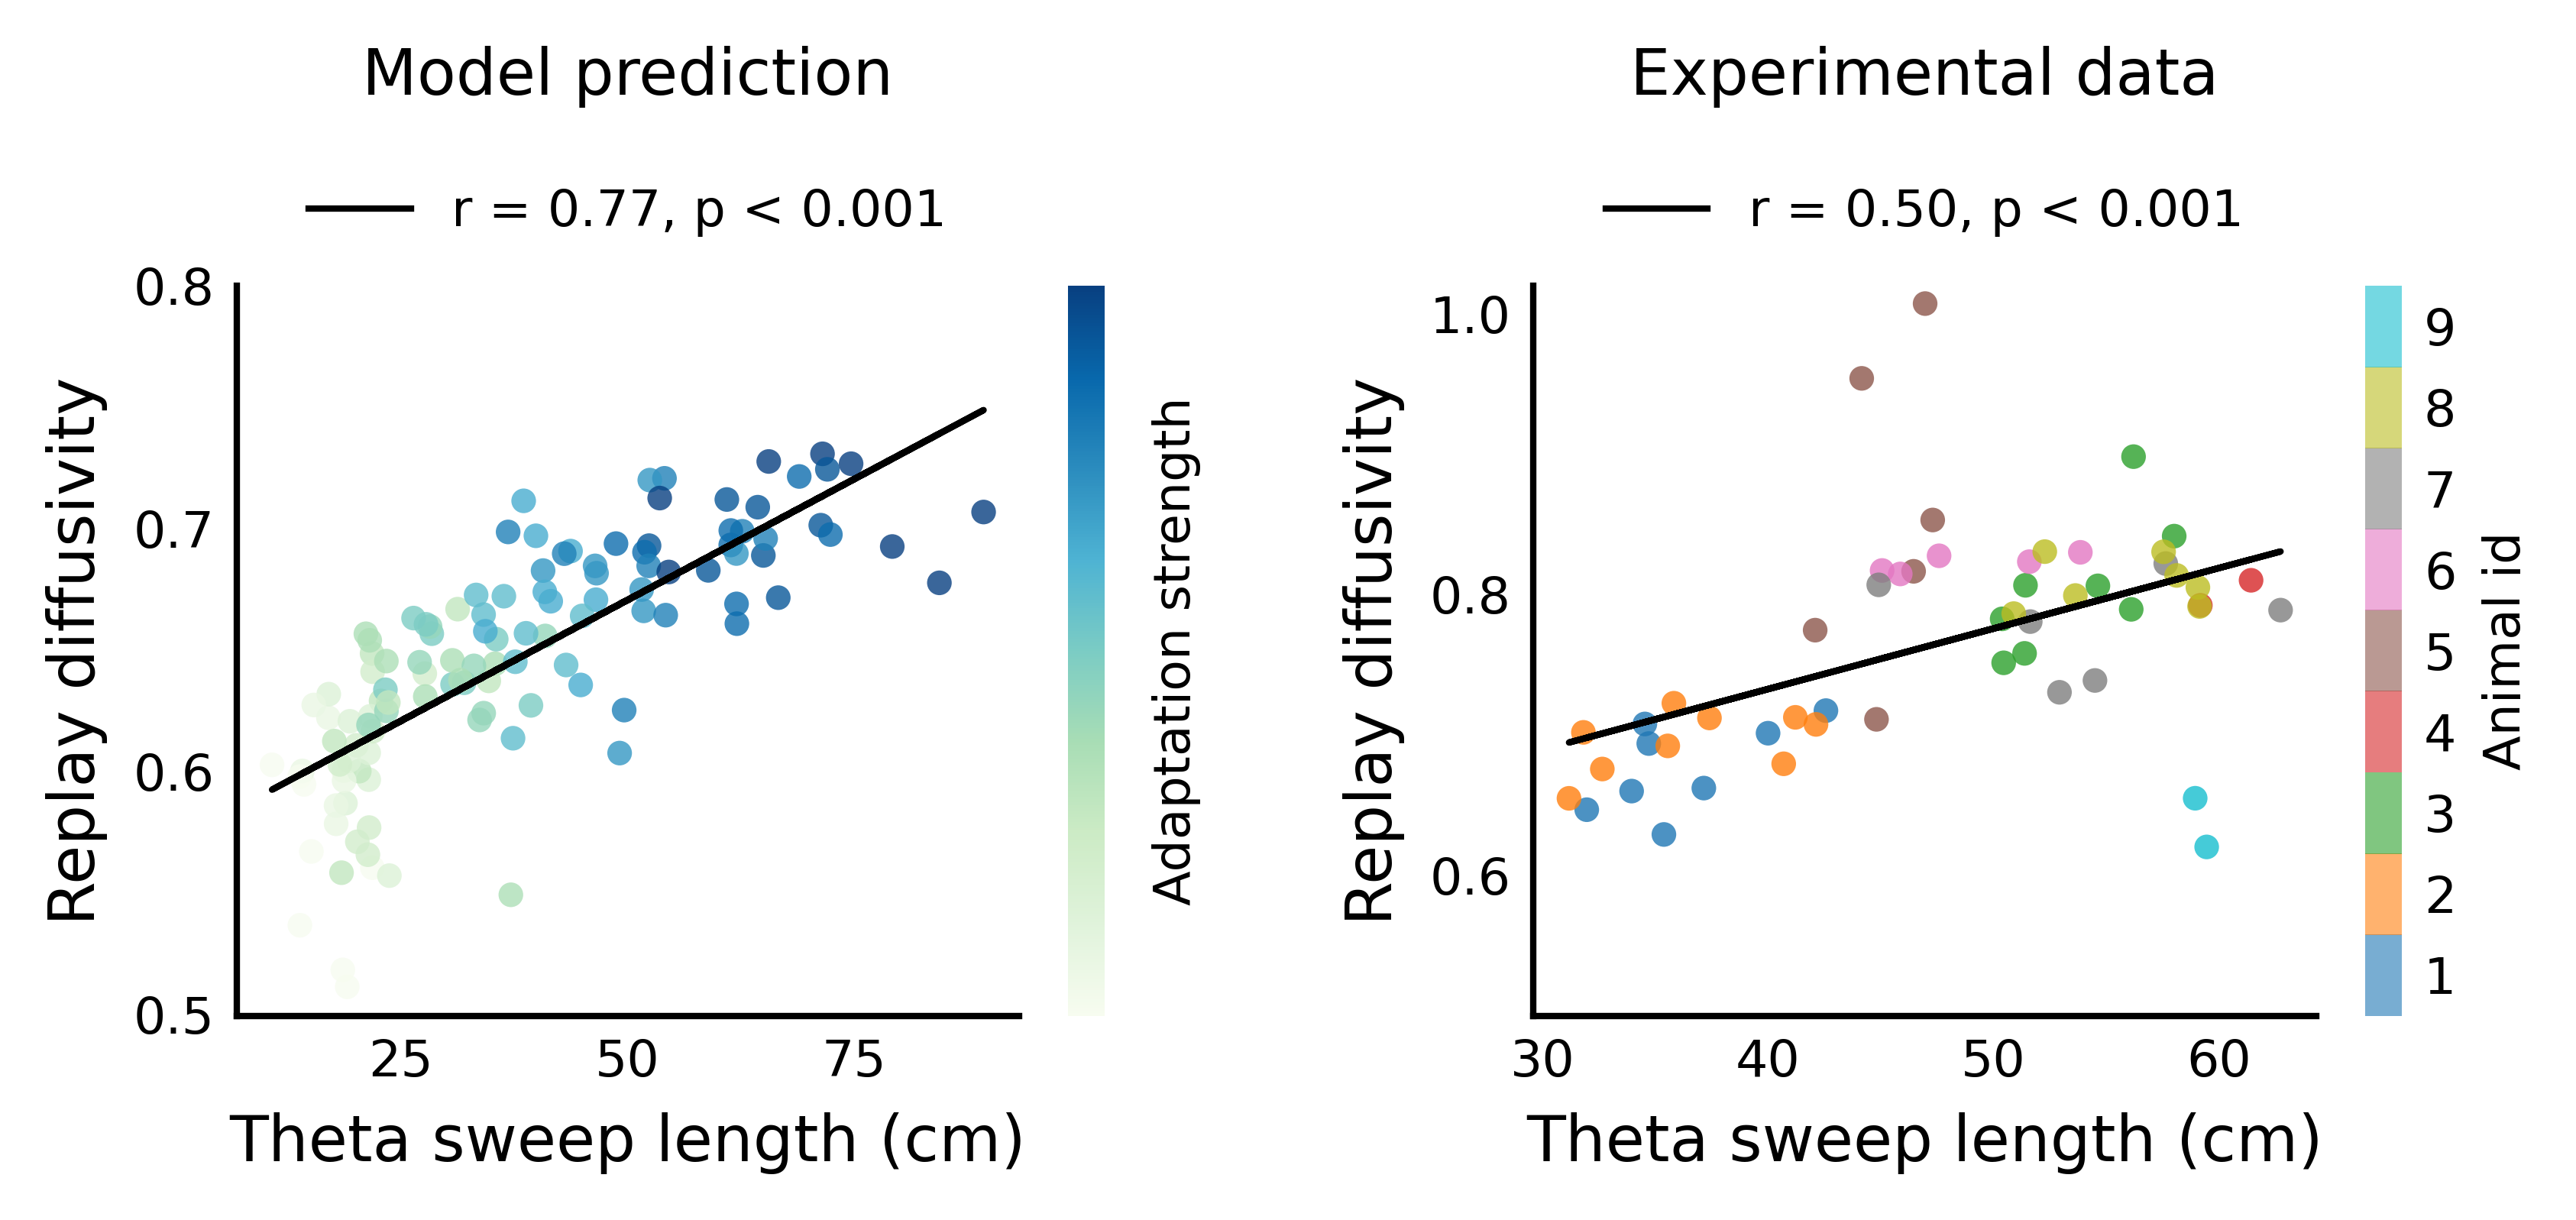

In [6]:
fig = plt.figure(figsize=(6, 3), dpi=300)
gs = gridspec.GridSpec(1, 2)
labelsize = 10
ticksize = 8
realtraj_color = "#009FB9"

# ax 3
ax0 = plt.subplot(gs[0])

# load the data from the pickle file
import pickle

with open(
    "/home/zilong/Desktop/AdaptiveAttractorForSequences/PaperFigureCode/sweep_replay_correlation.pkl",
    "rb",
) as f:
    M, MeanSweep, MeanSweepAmp, DiffusionExp = pickle.load(f)
cmap_user = "GnBu"
# Create a colormap scalar map
norm = Normalize(vmin=np.min(M), vmax=np.max(M))
cmap = cm.get_cmap(cmap_user)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # An empty array to create the color mapping

simulation_nums = DiffusionExp.shape[0]
for i in range(simulation_nums):
    ax0.scatter(
        MeanSweepAmp[i, :],
        DiffusionExp[i, :],
        c=M,
        cmap=cmap_user,
        s=15,
        alpha=0.8,
        edgecolors="none",
    )
# add linear fit line to the plot using numpy.polyfit
# convert MeanSweep and DiffusionExp from 2D array to 1D array
exp_np = DiffusionExp.flatten()
sweep_len_np = MeanSweepAmp.flatten()
slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
# pearson test
corr, p = pearsonr(sweep_len_np, exp_np)
if p < 0.001:
    ax0.plot(
        sweep_len_np,
        sweep_len_np * slope + intercept,
        "k-",
        label="r = %.2f, p < 0.001" % (corr),
        linewidth=1,
    )
else:
    ax0.plot(
        sweep_len_np,
        sweep_len_np * slope + intercept,
        "k-",
        label="r = %.2f, p = %.3f" % (corr, p),
        linewidth=1,
    )

# legend
ax0.legend(fontsize=ticksize, frameon=False, loc="center", bbox_to_anchor=(0.5, 1.1))

# Add a colorbar
cbar = plt.colorbar(sm, ax=ax0)
cbar.set_label("Adaptation strength", fontsize=ticksize)
# set colorbar box off
cbar.outline.set_visible(False)
# remove cbar tick labels
cbar.ax.set_yticklabels([])

ax0.set_xlabel("Theta sweep length (cm)", fontsize=labelsize)
ax0.set_ylabel("Replay diffusivity", fontsize=labelsize)
# ad title as 'Model prediction'
ax0.set_title("Model prediction", fontsize=labelsize, pad=30)
# change the xticks from meter to centermeter by times 100
ax0.set_xticks([0.25, 0.5, 0.75])
ax0.set_xticklabels([25, 50, 75])
# set y ticks
ax0.set_yticks([0.5, 0.6, 0.7, 0.8])

# ax1
ax1 = plt.subplot(gs[1])

# load real data: ./sweep_replay_correlation_realdata.pkl
# !!! need to run SeeepAwakeReplayCorrelation.ipynb first to generate the pickle file if not exist
with open("../../Processed-Data/sweep_replay_correlation_realdata.pkl", "rb") as f:
    (
        animal_names,
        all_sweep_len_perday_concat,
        all_sweep_amp_perday_concat,
        all_sweep_ahead_perday_concat,
        all_sweep_behind_perday_concat,
        all_exponent_perday_concat,
        all_ave_activespeed_perday_concat,
    ) = pickle.load(f)

# get the color for each animal
colors = plt.cm.get_cmap("tab10", len(animal_names))
color_dict = {}
for i, name in enumerate(animal_names):
    color_dict[name] = colors(i)

# plot the real data
for name in animal_names:
    ax1.scatter(
        np.array(all_sweep_amp_perday_concat[name]),
        np.array(all_exponent_perday_concat[name]),
        s=15,
        alpha=0.8,
        color=color_dict[name],
        edgecolors="none",
    )

# add linear fit line to the plot using numpy.polyfit
# convert all_sweep_len_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(all_exponent_perday_concat.values()))
sweep_len_np = np.concatenate(list(all_sweep_amp_perday_concat.values()))
slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
# pearson test
corr, p = pearsonr(sweep_len_np, exp_np)
# if p<0.001, then add label as 'r = %.2f, p < 0.001'; else add label as 'r = %.2f, p = %.3f'
if p < 0.001:
    ax1.plot(
        sweep_len_np,
        sweep_len_np * slope + intercept,
        "k-",
        label="r = %.2f, p < 0.001" % (corr),
        linewidth=1,
    )
else:
    ax1.plot(
        sweep_len_np,
        sweep_len_np * slope + intercept,
        "k-",
        label="r = %.2f, p = %.3f" % (corr, p),
        linewidth=1,
    )

# legend
ax1.legend(fontsize=ticksize, frameon=False, loc="center", bbox_to_anchor=(0.5, 1.1))


# add colorbar with alpha 0.8
cmap = ListedColormap(color_dict.values())
# Create a ScalarMappable with the colormap and normalize it
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(color_dict)))
# Set the colorbar properties
cbar = plt.colorbar(sm, ax=ax1, ticks=list(range(len(color_dict))), alpha=0.6)
# Set colorbar ticks by adding 1 to each tick
ticks = list(range(len(color_dict)))
cbar.set_ticks([tick + 0.5 for tick in ticks])
# set tick labels by adding 1 to each tick
cbar.set_ticklabels(list(range(1, len(color_dict) + 1)))
# Set colorbar ticklabels by adding 1 to each tick
# Set colorbar label
cbar.set_label("Animal id", fontsize=ticksize)
# remove the box of the colorbar
cbar.outline.set_visible(False)

ax1.set_xlabel("Theta sweep length (cm)", fontsize=labelsize)
ax1.set_ylabel("Replay diffusivity", fontsize=labelsize)
ax1.set_title("Experimental data", fontsize=labelsize, pad=30)
ax1.set_yticks([0.6, 0.8, 1.0])
ax1.set_ylim(0.5, 1.02)

# for all axes, set upper and right spine off, axis line width 1.0
all_axes = fig.get_axes()
for ax in all_axes:
    ax.tick_params(labelsize=ticksize)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # axis line width 1.0
    ax.spines["bottom"].set_linewidth(1.0)
    ax.spines["left"].set_linewidth(1.0)
    # remove the tick bars on the left and bottom
    ax.tick_params(axis="both", which="both", length=0)

plt.tight_layout()

# save the figure to /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/
savedir = "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/"

savename = "Fig_replay_vs_theta_sequences_correlation.pdf"
plt.savefig(savedir + savename, dpi=300, bbox_inches="tight")

In [146]:
animal_names

['bon', 'fra', 'gov', 'dud', 'con', 'dav', 'Cor', 'egy', 'cha']

### 4, plot the histogram of sweep length from two animals

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from tqdm.auto import tqdm

from loren_frank_data_processing import make_epochs_dataframe, make_neuron_dataframe
from src.parameters import ANIMALS, MIN_N_NEURONS, _BRAIN_AREAS
from ZilongCode.utils import (
    get_sweep_and_awake_replay_results_using_postive_negative_peak_in_LFP,
)

epoch_info = make_epochs_dataframe(ANIMALS)
neuron_info = make_neuron_dataframe(ANIMALS)

neuron_info = neuron_info.loc[
    (neuron_info.type == "principal")
    & (neuron_info.numspikes > 100)
    & neuron_info.area.isin(_BRAIN_AREAS)
]


n_neurons = (
    neuron_info.groupby(["animal", "day", "epoch"])
    .neuron_id.agg(len)
    .rename("n_neurons")
    .to_frame()
)

epoch_info = epoch_info.join(n_neurons)
is_w_track = epoch_info.environment.isin(["TrackA", "TrackB", "WTrackA", "WTrackB"])


####

animal_names = ["bon", "gov"]

sweep_bon = []
sweep_gov = []

replay_bon = []
replay_gov = []

DATA_DIR = "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data"

for name in animal_names:

    is_animal = epoch_info.index.isin([name], level="animal")

    valid_epochs = is_w_track & (epoch_info.n_neurons > MIN_N_NEURONS) & is_animal

    sweep_len = []
    sweep_amp = []
    sweep_ahead = []
    sweep_behind = []
    sweep_mass = []
    exponent = []
    intercept = []
    ave_speed = []
    ave_activespeed = []
    behav_exponent = []
    for epoch_key in tqdm(epoch_info[valid_epochs].index, desc="epochs"):
        animal, day, epoch = epoch_key

        # skip 'egy', 10, 2 since no mental_distance_from_actual_position is saved (double check later)
        if (animal, day, epoch) == ("egy", 10, 2):
            continue

        if (animal, day, epoch) == ("bon", 4, 2):
            continue

        print(f"Animal: {animal}, Day: {day}, Epoch: {epoch}")

        # get the average sweep length and replay exponent
        sweep_len, replay_stepsize, _ = get_sweep_length_and_replay_stepsize(
            epoch_key, datadir, sweep_speed_threshold=4
        )

        if name == "bon":
            sweep_bon.append(sweep_len)
            replay_bon.append(replay_stepsize)
        elif name == "gov":
            sweep_gov.append(sweep_len)
            replay_gov.append(replay_stepsize)
        else:
            print("error")
            break

epochs:   0%|          | 0/24 [00:00<?, ?it/s]

Animal: bon, Day: 3, Epoch: 2
Animal: bon, Day: 3, Epoch: 4
Animal: bon, Day: 3, Epoch: 6
Animal: bon, Day: 4, Epoch: 4
Animal: bon, Day: 4, Epoch: 6
Animal: bon, Day: 5, Epoch: 2
Animal: bon, Day: 5, Epoch: 4
Animal: bon, Day: 5, Epoch: 6
Animal: bon, Day: 6, Epoch: 2
Animal: bon, Day: 6, Epoch: 4
Animal: bon, Day: 6, Epoch: 6
Animal: bon, Day: 7, Epoch: 2
Animal: bon, Day: 7, Epoch: 4
Animal: bon, Day: 7, Epoch: 6
Animal: bon, Day: 8, Epoch: 2
Animal: bon, Day: 8, Epoch: 4
Animal: bon, Day: 8, Epoch: 6
Animal: bon, Day: 9, Epoch: 2
Animal: bon, Day: 9, Epoch: 4
Animal: bon, Day: 9, Epoch: 6
Animal: bon, Day: 10, Epoch: 2
Animal: bon, Day: 10, Epoch: 4
Animal: bon, Day: 10, Epoch: 6


epochs:   0%|          | 0/24 [00:00<?, ?it/s]

Animal: gov, Day: 6, Epoch: 2
Animal: gov, Day: 6, Epoch: 4
Animal: gov, Day: 6, Epoch: 6
Animal: gov, Day: 7, Epoch: 2
Animal: gov, Day: 7, Epoch: 4
Animal: gov, Day: 7, Epoch: 6
Animal: gov, Day: 8, Epoch: 2
Animal: gov, Day: 8, Epoch: 4
Animal: gov, Day: 8, Epoch: 6
Animal: gov, Day: 9, Epoch: 2
Animal: gov, Day: 9, Epoch: 3
Animal: gov, Day: 9, Epoch: 5
Animal: gov, Day: 10, Epoch: 2
Animal: gov, Day: 10, Epoch: 4
Animal: gov, Day: 10, Epoch: 6
Animal: gov, Day: 11, Epoch: 2
Animal: gov, Day: 11, Epoch: 4
Animal: gov, Day: 11, Epoch: 6
Animal: gov, Day: 12, Epoch: 2
Animal: gov, Day: 12, Epoch: 4
Animal: gov, Day: 12, Epoch: 6
Animal: gov, Day: 13, Epoch: 2
Animal: gov, Day: 13, Epoch: 4
Animal: gov, Day: 13, Epoch: 6


25.335136107047305 30.06951950825663


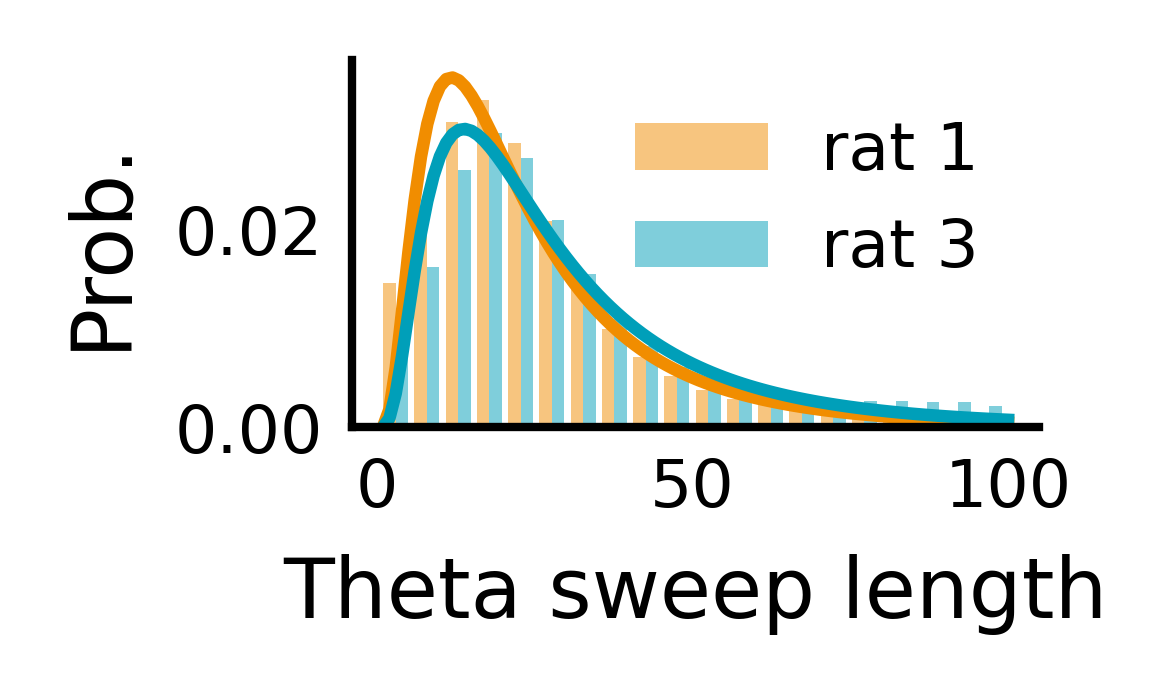

In [17]:
from scipy.stats import lognorm

# merge sweep_bon into a single array
sweep_bon_all = np.concatenate(sweep_bon)
sweep_gov_all = np.concatenate(sweep_gov)

replay_bon_all = np.concatenate(replay_bon)
replay_gov_all = np.concatenate(replay_gov)

# plot the histgram of sweep_len1 and sweep_len2 in one plot with different colors
fig, ax = plt.subplots(1, 1, figsize=(2.2, 1.5), dpi=300)
labelsize = 10
ticksize = 8

start = 1
end = 100

# remove len <5 and >100
sweep_bon_all = sweep_bon_all[(sweep_bon_all > start) & (sweep_bon_all < end)]
sweep_gov_all = sweep_gov_all[(sweep_gov_all > start) & (sweep_gov_all < end)]


# Fit a log-normal distribution to the 'bon' data
shape_bon, loc_bon, scale_bon = lognorm.fit(sweep_bon_all, floc=0)
# Fit a log-normal distribution to the 'gov' data
shape_gov, loc_gov, scale_gov = lognorm.fit(sweep_gov_all, floc=0)

# Generate x values for plotting the fitted distribution
x_values = np.linspace(
    min(sweep_bon_all.min(), sweep_gov_all.min()),
    max(sweep_bon_all.max(), sweep_gov_all.max()),
    100,
)

# Calculate the fitted log-normal distribution values
fitted_pdf_bon = lognorm.pdf(x_values, shape_bon, loc_bon, scale_bon)
fitted_pdf_gov = lognorm.pdf(x_values, shape_gov, loc_gov, scale_gov)

bins = np.linspace(start, end, 21)
width = (bins[1] - bins[0]) / 2.5

# plot the hist in a normalized way
ax.hist(
    sweep_bon_all,
    bins=bins,
    color="#F18D00",
    alpha=0.5,
    width=width,
    label="rat 1",
    density=True,
    align="mid",
    edgecolor="none",
)
ax.hist(
    sweep_gov_all,
    bins=bins,
    color="#009FB9",
    alpha=0.5,
    width=width,
    label="rat 3",
    density=True,
    align="mid",
    rwidth=0.2,
    edgecolor="none",
)

# Plotting the fitted distributions
ax.plot(x_values, fitted_pdf_bon, lw=1.5, color="#F18D00")
ax.plot(x_values, fitted_pdf_gov, lw=1.5, color="#009FB9")

ax.set_xlabel("Theta sweep length", fontsize=labelsize)
ax.legend(fontsize=ticksize, frameon=False)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(1.0)
ax.spines["bottom"].set_linewidth(1.0)

ax.tick_params(axis="both", which="major", labelsize=ticksize)
ax.set_ylabel("Prob.", fontsize=labelsize)
# remove the tick bars
ax.tick_params(axis="y", length=0)
ax.tick_params(axis="x", length=0)

plt.tight_layout()

# save the figure to /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/
savedir = "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/"
savename = "Fig_replay_vs_theta_sequences_bon_gov_theta.pdf"

plt.savefig(savedir + savename, dpi=300, bbox_inches="tight")
print(np.mean(sweep_bon_all), np.mean(sweep_gov_all))

[-0.3310728  10.55753805 76.05293227] [3.10395135e-02 1.47499996e+01 7.49945559e+01]


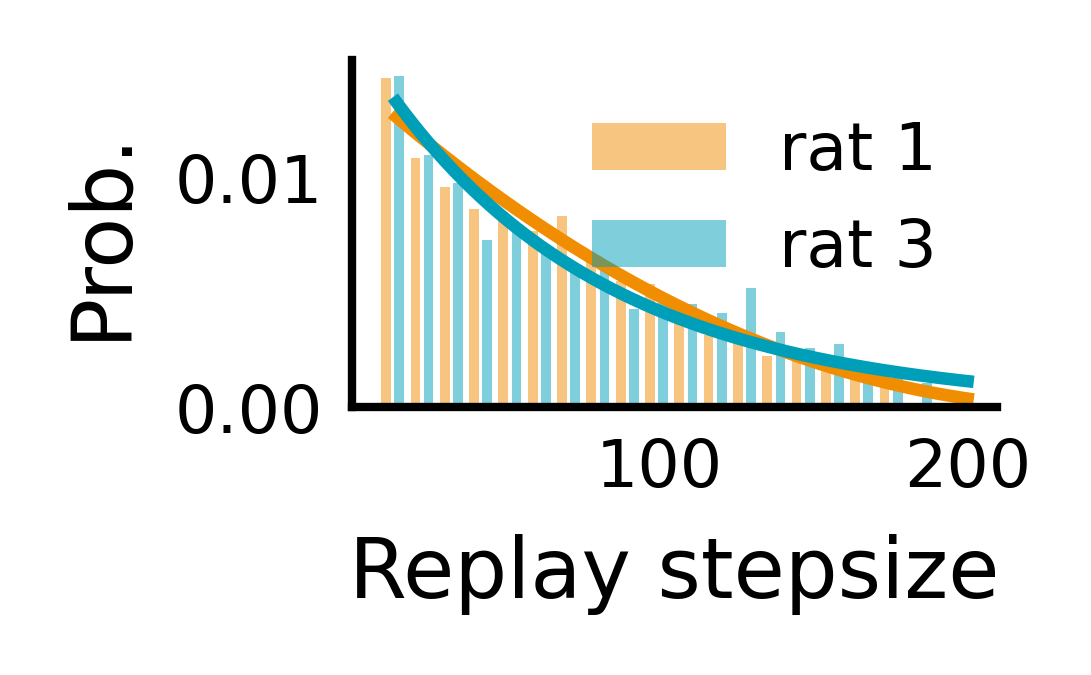

In [16]:
from scipy.stats import genpareto
from scipy.optimize import curve_fit

# plot replay stepsize in one plot
fig, ax = plt.subplots(1, 1, figsize=(2.2, 1.5), dpi=300)
labelsize = 10
ticksize = 8

replay_bon_all = np.concatenate(replay_bon)
replay_gov_all = np.concatenate(replay_gov)

start = 10
end = 200

# remove len <5 and >100
replay_bon_all = replay_bon_all[(replay_bon_all > start) & (replay_bon_all < end)]
replay_gov_all = replay_gov_all[(replay_gov_all > start) & (replay_gov_all < end)]


# plot the hist in a normalized way
bins = np.linspace(start, end, 21)
width = (bins[1] - bins[0]) / 3

# Define the function to estimate using the GPD
# The GPD can be parameterized with location (c), scale (scale), and shape (k) parameters.
def gen_pareto_pdf(x, c, scale, k):
    return genpareto.pdf(x, c, loc=scale, scale=k)


# Calculate histogram data
hist_bon, bin_edges_bon = np.histogram(replay_bon_all, bins=bins, density=True)
hist_gov, bin_edges_gov = np.histogram(replay_gov_all, bins=bins, density=True)

# Compute bin centers
bin_centers_bon = (bin_edges_bon[:-1] + bin_edges_bon[1:]) / 2
bin_centers_gov = (bin_edges_gov[:-1] + bin_edges_gov[1:]) / 2

# Fit the GPD to the 'bon' histogram data
params_bon, _ = curve_fit(gen_pareto_pdf, bin_centers_bon, hist_bon, p0=[10, 10, 0.1])

# Fit the GPD to the 'gov' histogram data
params_gov, _ = curve_fit(gen_pareto_pdf, bin_centers_gov, hist_gov, p0=[10, 10, 0.1])

print(params_bon, params_gov)
# Generate the x values for plotting the fitted distribution
x_values = np.linspace(start + 5, end, 400)

# Calculate the fitted GPD values
fitted_pdf_bon = gen_pareto_pdf(x_values, *params_bon)
fitted_pdf_gov = gen_pareto_pdf(x_values, *params_gov)


# plot the hist in a normalized way
ax.hist(
    replay_bon_all,
    bins=bins,
    color="#F18D00",
    alpha=0.5,
    width=width,
    label="rat 1",
    density=True,
    align="mid",
    edgecolor="none",
)
ax.hist(
    replay_gov_all,
    bins=bins,
    color="#009FB9",
    alpha=0.5,
    width=width,
    label="rat 3",
    density=True,
    align="mid",
    rwidth=0.1,
    edgecolor="none",
)

# plot the fitted power-law distributions
ax.plot(x_values, fitted_pdf_bon, lw=1.5, color="#F18D00")
ax.plot(x_values, fitted_pdf_gov, lw=1.5, color="#009FB9")

ax.set_xlabel("Replay stepsize", fontsize=labelsize)
ax.legend(fontsize=ticksize, frameon=False)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(1.0)
ax.spines["bottom"].set_linewidth(1.0)

ax.tick_params(axis="both", which="major", labelsize=ticksize)
ax.set_ylabel("Prob.", fontsize=labelsize)
# remove the tick bars
ax.tick_params(axis="y", length=0)
ax.tick_params(axis="x", length=0)

plt.tight_layout()

# save the figure to /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/
savedir = "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/"
savename = "Fig_replay_vs_theta_sequences_bon_gov_replay.pdf"

plt.savefig(savedir + savename, dpi=300, bbox_inches="tight")

### 5, check the correlation of both factors with place field size index

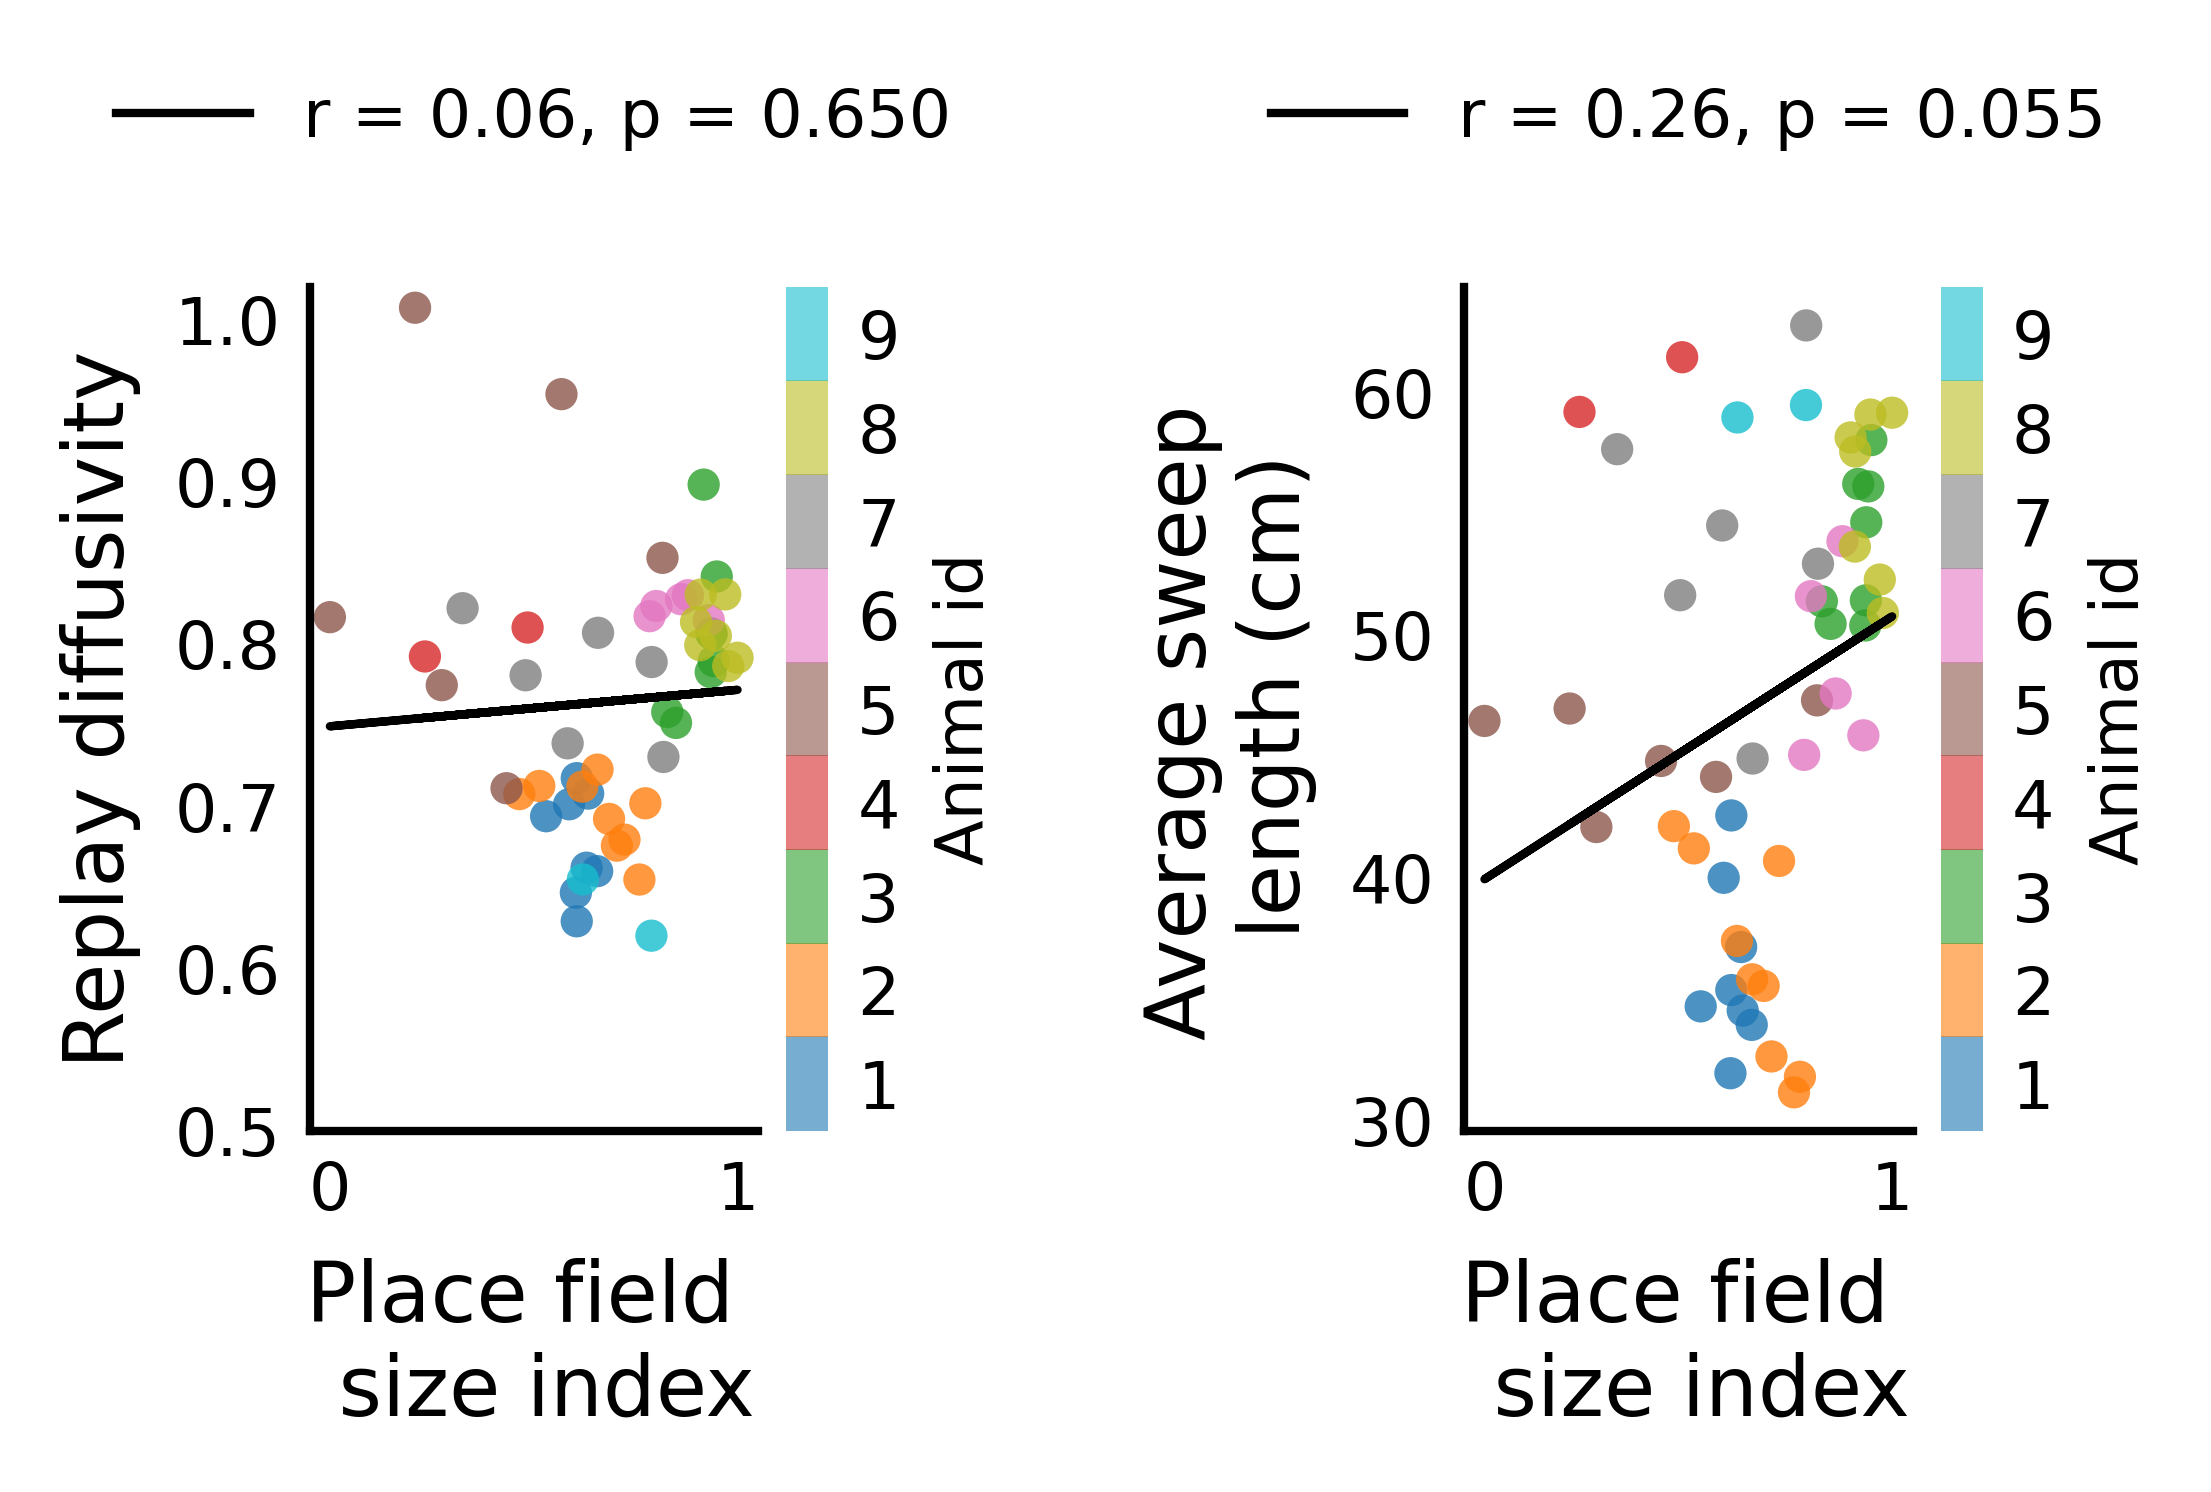

In [15]:
fig = plt.figure(figsize=(4, 3), dpi=300)
gs = gridspec.GridSpec(1, 2)
labelsize = 10
ticksize = 8
realtraj_color = "#009FB9"

# load real data: ./sweep_replay_correlation_realdata.pkl
# !!! need to run SeeepAwakeReplayCorrelation.ipynb first to generate the pickle file if not exist
with open("../../Processed-Data/sweep_replay_correlation_realdata.pkl", "rb") as f:
    (
        animal_names,
        all_sweep_len_perday_concat,
        all_sweep_amp_perday_concat,
        all_sweep_ahead_perday_concat,
        all_sweep_behind_perday_concat,
        all_exponent_perday_concat,
        all_ave_activespeed_perday_concat,
    ) = pickle.load(f)

# get the color for each animal
colors = plt.cm.get_cmap("tab10", len(animal_names))
color_dict = {}
for i, name in enumerate(animal_names):
    color_dict[name] = colors(i)


# ax2
# !!! need to run CorrelationwithPVC.ipynb first to generate the pickle file if not exist
# './sweep_replay_correlation_with_PVC.pickle'
with open("./sweep_replay_correlation_with_PVC.pickle", "rb") as f:
    (
        all_offsets,
        all_mean_diagonal_sums,
        all_corr_matrix,
        all_unique_nan_index,
        animal_names,
        all_corrbin_perday_concat,
        all_sweep_len_perday_concat,
        all_peak_sweep_len_perday_concat,
        all_exponent_perday_concat,
    ) = pickle.load(f)

# take the inverse of each element in all_corrbin_perday_concat
for name in animal_names:
    all_corrbin_perday_concat[name] = [
        1 - corrbin for corrbin in all_corrbin_perday_concat[name]
    ]

# find the min and max in all_corrbin_perday_concat
min_corrbin = np.min(np.concatenate(list(all_corrbin_perday_concat.values())))
max_corrbin = np.max(np.concatenate(list(all_corrbin_perday_concat.values())))

# normalize all_corrbin_perday_concat to 0-1
for name in animal_names:
    all_corrbin_perday_concat[name] = [
        (corrbin - min_corrbin) / (max_corrbin - min_corrbin)
        for corrbin in all_corrbin_perday_concat[name]
    ]

# ax2
ax2 = plt.subplot(gs[0])

# plot all_exponent_perday_concat against all_sweep_len_perday_concat
for name in animal_names:
    ax2.scatter(
        np.array(all_corrbin_perday_concat[name]),
        np.array(all_exponent_perday_concat[name]),
        s=15,
        alpha=0.8,
        color=color_dict[name],
        edgecolors="none",
    )
# add linear fit line to the plot using numpy.polyfit
# convert all_ave_speed_perday_concat and all_exponent_perday_concat to numpy array
corrbin_np = np.concatenate(list(all_corrbin_perday_concat.values()))
exponent_np = np.concatenate(list(all_exponent_perday_concat.values()))
slope, intercept = np.polyfit(corrbin_np, exponent_np, 1)
# pearson test
corr, p = pearsonr(corrbin_np, exponent_np)
ax2.plot(
    corrbin_np,
    corrbin_np * slope + intercept,
    "k-",
    label="r = %.2f, p = %.3f" % (corr, p),
    linewidth=1,
)

# legend
ax2.legend(fontsize=ticksize, frameon=False, loc="center", bbox_to_anchor=(0.5, 1.2))

# add colorbar with alpha 0.8
cmap = ListedColormap(color_dict.values())
# Create a ScalarMappable with the colormap and normalize it
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(color_dict)))
# Set the colorbar properties
cbar = plt.colorbar(sm, ax=ax2, ticks=list(range(len(color_dict))), alpha=0.6)
# Set colorbar ticks by adding 1 to each tick
ticks = list(range(len(color_dict)))
cbar.set_ticks([tick + 0.5 for tick in ticks])
# set tick labels by adding 1 to each tick
cbar.set_ticklabels(list(range(1, len(color_dict) + 1)))
# Set colorbar ticklabels by adding 1 to each tick
# Set colorbar label
cbar.set_label("Animal id", fontsize=ticksize)
# remove the box of the colorbar
cbar.outline.set_visible(False)

ax2.set_xlabel("Place field \n size index", fontsize=labelsize)
ax2.set_ylabel("Replay diffusivity", fontsize=labelsize)
ax2.set_ylim([0.5, 1.02])


# ax3
ax3 = plt.subplot(gs[1])

# plot all_intercept_perday_concat against all_ave_speed_perday_concat
for name in animal_names:
    plt.scatter(
        np.array(all_corrbin_perday_concat[name]),
        np.array(all_peak_sweep_len_perday_concat[name]),
        s=15,
        alpha=0.8,
        color=color_dict[name],
        edgecolors="none",
    )
# add linear fit line to the plot using numpy.polyfit
# convert all_ave_speed_perday_concat and all_exponent_perday_concat to numpy array
corrbin_np = np.concatenate(list(all_corrbin_perday_concat.values()))
sweep_len_np = np.concatenate(list(all_peak_sweep_len_perday_concat.values()))
slope, intercept = np.polyfit(corrbin_np, sweep_len_np, 1)
# pearson test
corr, p = pearsonr(corrbin_np, sweep_len_np)
ax3.plot(
    corrbin_np,
    corrbin_np * slope + intercept,
    "k-",
    label="r = %.2f, p = %.3f" % (corr, p),
    linewidth=1,
)

# legend
ax3.legend(fontsize=ticksize, frameon=False, loc="center", bbox_to_anchor=(0.5, 1.2))

# add colorbar with alpha 0.8
cmap = ListedColormap(color_dict.values())
# Create a ScalarMappable with the colormap and normalize it
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(color_dict)))
# Set the colorbar properties
cbar = plt.colorbar(sm, ax=ax3, ticks=list(range(len(color_dict))), alpha=0.6)
# Set colorbar ticks by adding 1 to each tick
ticks = list(range(len(color_dict)))
cbar.set_ticks([tick + 0.5 for tick in ticks])
# set tick labels by adding 1 to each tick
cbar.set_ticklabels(list(range(1, len(color_dict) + 1)))
# Set colorbar ticklabels by adding 1 to each tick
# Set colorbar label
cbar.set_label("Animal id", fontsize=ticksize)
# remove the box of the colorbar
cbar.outline.set_visible(False)

ax3.set_xlabel("Place field \n size index", fontsize=labelsize)
ax3.set_ylabel("Average sweep \n length (cm)", fontsize=labelsize)


# for all axes, set upper and right spine off, axis line width 1.0
all_axes = fig.get_axes()
for ax in all_axes:
    ax.tick_params(labelsize=ticksize)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # axis line width 1.0
    ax.spines["bottom"].set_linewidth(1.0)
    ax.spines["left"].set_linewidth(1.0)
    # remove the tick bars on the left and bottom
    ax.tick_params(axis="both", which="both", length=0)

plt.tight_layout()

# save the figure to /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/
savedir = "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/"

savename = "Fig_replay_vs_theta_sequences_correlatewithplacefieldsize.pdf"
plt.savefig(savedir + savename, dpi=300, bbox_inches="tight")